In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 1
setup_one_gpu(GPU)

Picking GPU 1


In [2]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from general_tools.notebook.tf import reset_tf_graph
from general_tools.in_out.basics import create_dir, files_in_subdirs

from geo_tool import Point_Cloud

from tf_lab.in_out.basics import Data_Splitter, read_saved_epochs
from tf_lab.point_clouds.ae_templates import mlp_architecture_ala_iclr_18, default_train_params

from tf_lab.point_clouds.autoencoder import Configuration as Conf
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder

from tf_lab.point_clouds.in_out import load_point_clouds_from_filenames, PointCloudDataSet
from tf_lab.data_sets.shape_net import pc_loader as snc_loader
from tf_lab.data_sets.shape_net import snc_category_to_synth_id

from tf_lab.point_clouds.latent_gan import LatentGAN
from tf_lab.point_clouds.generators_discriminators import latent_code_discriminator_two_layers, \
latent_code_generator_two_layers, latent_code_discriminator, latent_code_generator

from tf_lab.iclr.helper import load_multiple_version_of_pcs, find_best_validation_epoch_from_train_stats
from tf_lab.point_clouds.convenience import get_latent_codes
from tf_lab.neural_net import MODEL_SAVER_ID

from tf_lab.point_clouds.raw_gan_gp import RawGAN_GP
from tf_lab.point_clouds.generators_discriminators import latent_code_generator

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [19]:
n_pc_points = 2048
random_seed = 42
do_training = True
plot_train_curve = True 
save_synthetic_samples = True
save_model = False
saver_step = np.hstack([np.array([1, 5, 10]), np.arange(50, 1001, 50)])
ae_loss = 'emd'
do_wgan = True
class_name = 'achlioptas_5_snc'
b_neck = int(raw_input('Give me bneck_size.\n'))
ae_tag = 'mlp_with_split_1pc_usampled'

Give me bneck_size.
128


In [5]:
if do_wgan:
    gan_tag = 'l_w_gan'
else:
    gan_tag = 'l_gan'

experiment_tag = '_'.join([gan_tag, class_name, ae_tag, ae_loss, 'bneck', str(b_neck)])
print experiment_tag

l_w_gan_achlioptas_snc_5_medium_mlp_with_split_1pc_usampled_emd_bneck_128


In [12]:
top_data_dir = '/orions4-zfs/projects/optas/DATA/'
top_pclouds_path = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Core/from_manifold_meshes/centered/', str(n_pc_points))
train_split = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Splits/achlioptas_snc_5_medium_size_splits/train.txt')
val_split = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Splits/achlioptas_snc_5_medium_size_splits/val.txt')
splitter = Data_Splitter(top_pclouds_path, data_file_ending='.ply', random_seed=random_seed)
tr_files = splitter.load_splits(train_split)
pclouds, model_ids, syn_ids = load_point_clouds_from_filenames(tr_files, n_threads=20, loader=snc_loader, verbose=True)
train_data = PointCloudDataSet(pclouds, labels=syn_ids + '_' + model_ids)
val_files = splitter.load_splits(val_split)
pclouds, model_ids, syn_ids = load_point_clouds_from_filenames(val_files, n_threads=20, loader=snc_loader, verbose=True)
val_data = PointCloudDataSet(pclouds, labels=syn_ids + '_' + model_ids)

10000 pclouds were loaded. They belong in 5 shape-classes.
500 pclouds were loaded. They belong in 5 shape-classes.


In [22]:
synthetic_data_out_dir = osp.join(top_data_dir, 'OUT/iclr/synthetic_samples/', experiment_tag)
create_dir(synthetic_data_out_dir)
train_dir = osp.join(top_data_dir, 'OUT/iclr/nn_models', experiment_tag)
create_dir(train_dir)

'/orions4-zfs/projects/optas/DATA/OUT/iclr/nn_models/l_w_gan_achlioptas_snc_5_medium_mlp_with_split_1pc_usampled_emd_bneck_128'

In [10]:
# Load Auto-Encoder
ae_id = '_'.join(['ae_mlp_on_achlioptas_5_snc_2048_pts', str(b_neck), 'bneck', ae_loss])
ae_train_dir = osp.join(top_data_dir, 'OUT/iclr/nn_models/', ae_id)
ae_conf = Conf.load(osp.join(ae_train_dir, 'configuration'))
saved_epochs = read_saved_epochs(ae_conf.train_dir)
_, best_epoch = find_best_validation_epoch_from_train_stats(osp.join(ae_train_dir, 'train_stats.txt'))
if best_epoch % ae_conf.saver_step != 0: # Model was not saved at that epoch.
    best_epoch += best_epoch % ae_conf.saver_step
ae_conf.encoder_args['verbose'] = False
ae_conf.decoder_args['verbose'] = False
reset_tf_graph()
ae = PointNetAutoEncoder(ae_conf.experiment_name, ae_conf)    
ae.restore_model(ae_conf.train_dir, best_epoch, verbose=True)

Model restored in epoch 820.


In [15]:
# Convert raw-data to latent codes.
latent_codes = get_latent_codes(ae, train_data.point_clouds)
train_data = PointCloudDataSet(latent_codes)

In [16]:
init_lr = 0.0001
batch_size = 50
noise_params = {'mu':0, 'sigma': 0.2}
noise_dim = b_neck
max_epochs = 1000
n_syn_samples = train_data.num_examples
n_out = [b_neck]
accum_syn_data = []
train_stats = []

In [17]:
reset_tf_graph()

if do_wgan:
    lam = 10
    beta = 0.5
    reset_tf_graph()
    gan = RawGAN_GP(experiment_tag, init_lr, lam, n_out, noise_dim, \
                    latent_code_discriminator, latent_code_generator, \
                    beta=beta, gen_kwargs={'layer_sizes': [64, 128], 'b_norm': False}, 
                    disc_kwargs={'layer_sizes': [512, 1024], 'b_norm': False})
else:
    beta = 0.0
    gan = LatentGAN(experiment_tag, init_lr, n_out, noise_dim, latent_code_discriminator_two_layers,
                    latent_code_generator_two_layers, beta=beta, gen_kwargs={'b_norm': False}, 
                    disc_kwargs={'b_norm': False})

2 (-0.99652312487363814, -0.37694298103451729)
3 (-0.81618488252162935, -0.22075160685926676)
4 (-0.74784807324409486, 0.037703336728736755)
5 (-0.73964997977018354, 0.11555604627355934)


/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


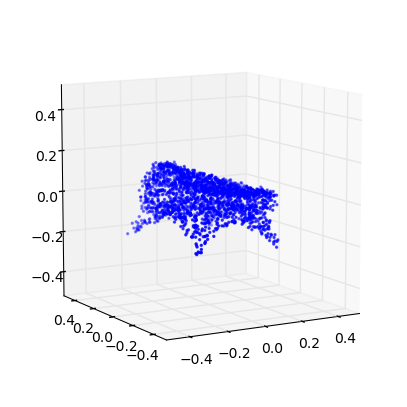

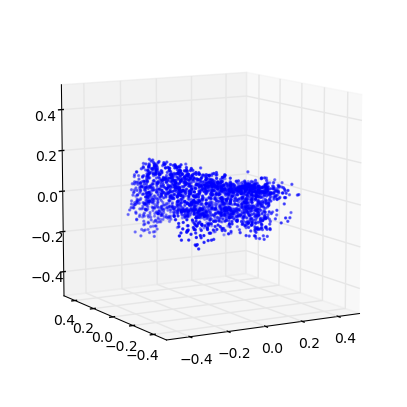

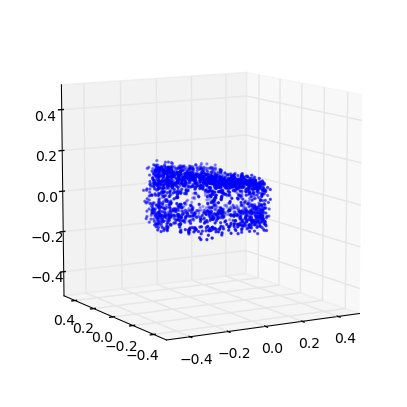

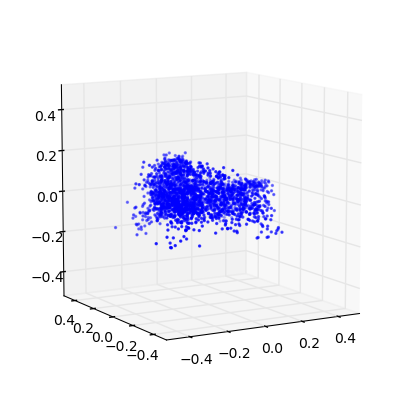

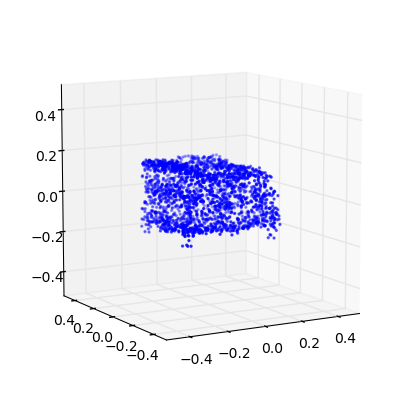

6 (-0.71793363094329832, 0.11627213340252637)
7 (-0.69540365636348722, 0.10915736239403487)
8 (-0.66593667924404143, 0.093997785542160275)
9 (-0.62852213472127916, 0.079930650023743513)
10 (-0.58565812468528744, 0.072703701339196417)


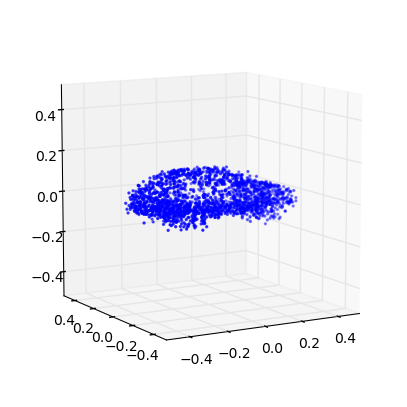

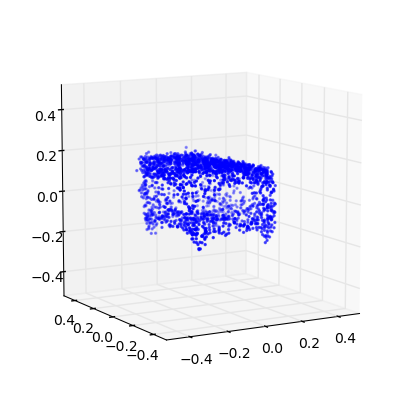

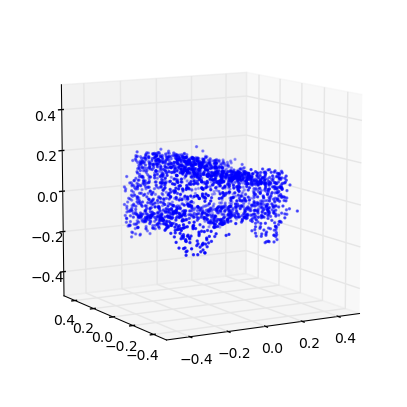

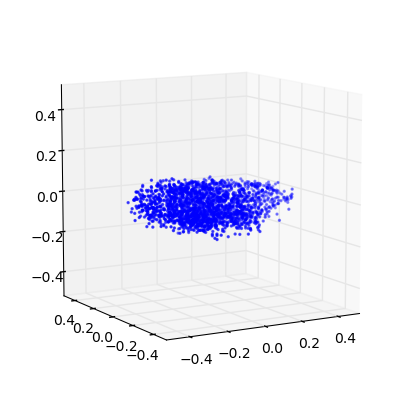

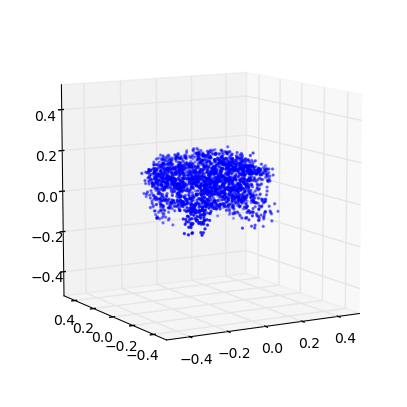

11 (-0.54128823205828669, 0.075816658604890105)
12 (-0.49786030501127243, 0.08144193422049284)
13 (-0.45978767052292824, 0.11007555406540633)
14 (-0.43248392760753629, 0.13514355560764671)
15 (-0.4183108611404896, 0.17324581593275071)
16 (-0.4093689662218094, 0.20180889442563058)
17 (-0.40053620263934137, 0.24238002859055996)
18 (-0.39404690980911256, 0.25080300383269788)
19 (-0.38801651924848557, 0.27458344623446462)
20 (-0.38567268714308739, 0.26307986639440062)
21 (-0.38694104462862017, 0.27459230907261373)
22 (-0.3841602545976639, 0.29262534081935881)
23 (-0.38220190599560738, 0.29146077483892441)
24 (-0.37981398060917854, 0.3032508432865143)
25 (-0.37959292680025103, 0.30943159610033033)
26 (-0.37514586150646212, 0.3018563136458397)
27 (-0.37152200058102608, 0.29191008470952512)
28 (-0.37104039922356608, 0.29131290577352048)
29 (-0.36776465803384784, 0.27799343056976794)
30 (-0.36195759028196334, 0.27885607779026034)
31 (-0.36127096071839332, 0.2647927962243557)
32 (-0.35963152512

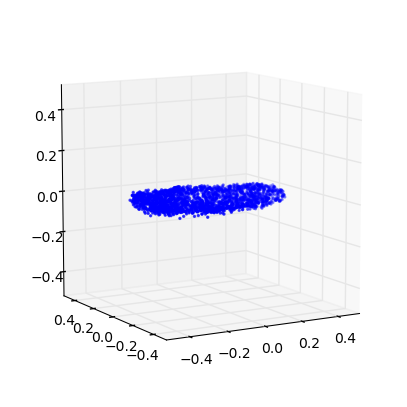

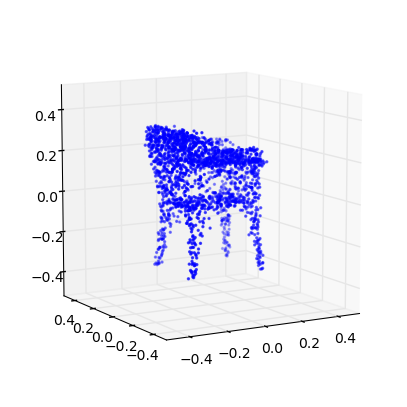

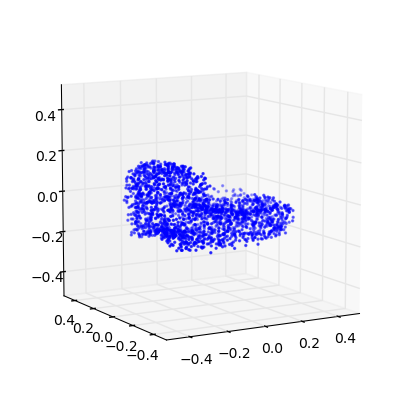

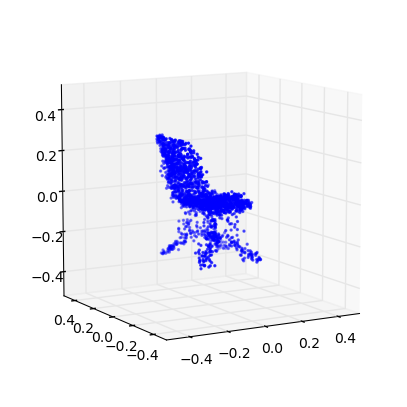

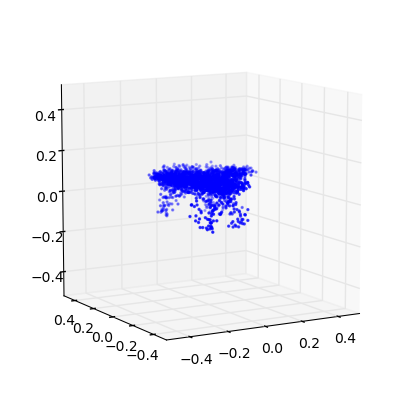

51 (-0.33056801810860637, 0.16153903715312481)
52 (-0.33085504949092864, 0.16302578654140235)
53 (-0.33112119033932685, 0.15213796868920326)
54 (-0.32932373285293581, 0.13984567243605853)
55 (-0.32722950890660285, 0.13813581131398678)
56 (-0.32615323528647422, 0.13711002059280872)
57 (-0.32581493735313416, 0.14198193904012441)
58 (-0.32508269429206849, 0.12871067877858877)
59 (-0.32403460025787356, 0.12917001228779554)
60 (-0.32250399768352511, 0.1337635787203908)
61 (-0.3227925778925419, 0.12256561946123838)
62 (-0.3184153752028942, 0.10942998863756656)
63 (-0.3206552851200104, 0.11341602094471455)
64 (-0.31812080219388006, 0.10945557812228798)
65 (-0.31867505192756651, 0.1111956287175417)
66 (-0.31488000035285951, 0.10766875389963389)
67 (-0.31520607054233551, 0.1144328374415636)
68 (-0.31126683324575422, 0.10303094778209924)
69 (-0.31233368851244447, 0.11408996097743511)
70 (-0.31237372577190398, 0.10597363039851189)
71 (-0.31081325225532053, 0.10339943366125226)
72 (-0.311611934080

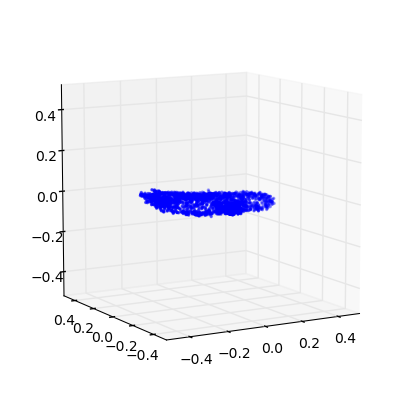

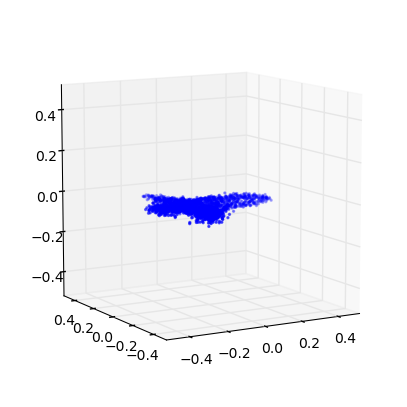

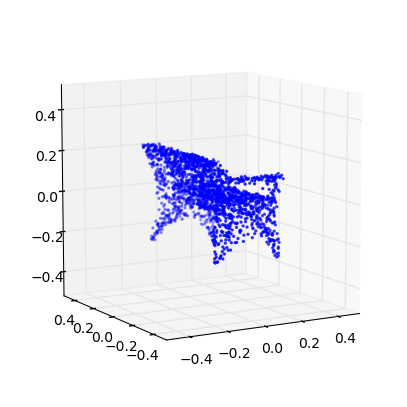

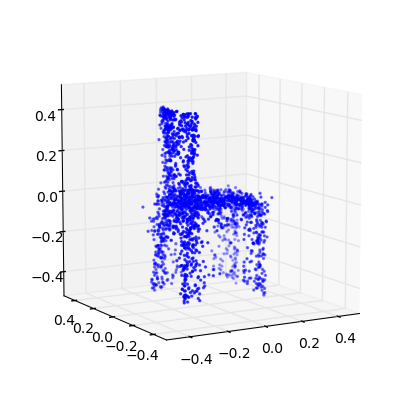

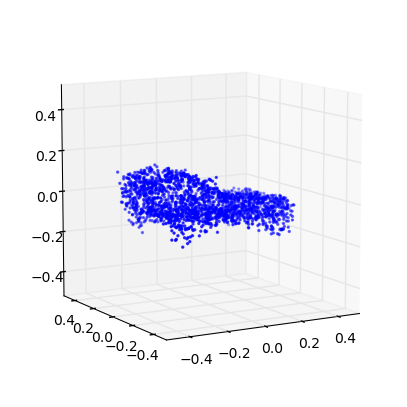

101 (-0.29336581356823443, 0.058102166606113316)
102 (-0.29149547912180424, 0.05538300885818899)
103 (-0.2889750289171934, 0.048784138960763813)
104 (-0.2888613659143448, 0.04732273485278711)
105 (-0.2889279667288065, 0.043686672137118875)
106 (-0.28917883940041067, 0.042941654438618568)
107 (-0.28985683716833593, 0.043891904526390135)
108 (-0.28867648042738436, 0.041107867972459647)
109 (-0.28949206627905366, 0.029563429340487345)
110 (-0.28825395859777925, 0.040056624147109685)
111 (-0.2873972959071398, 0.028151557903038339)
112 (-0.28492284022271636, 0.030993998958729209)
113 (-0.28703898318111898, 0.035204817494377497)
114 (-0.28472509354352948, 0.026454024738632141)
115 (-0.2835235943645239, 0.02448843759484589)
116 (-0.28414882600307467, 0.025799533573444933)
117 (-0.28276197075843812, 0.019942283048294485)
118 (-0.27909898705780506, 0.013043225836008787)
119 (-0.28187100566923617, 0.01580234951688908)
120 (-0.28226957991719248, 0.0091667835542466498)
121 (-0.28117543250322341, 0

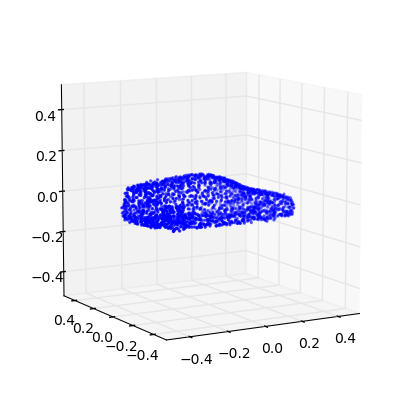

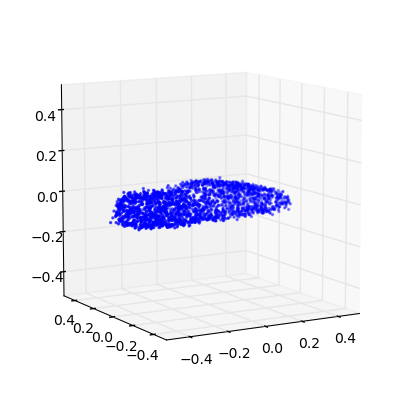

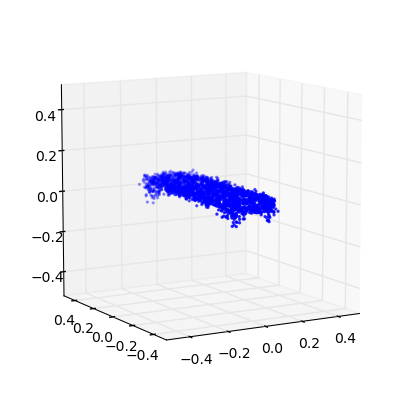

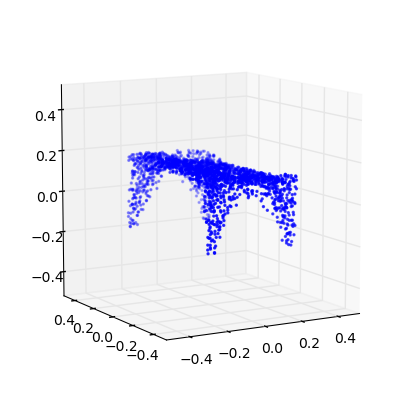

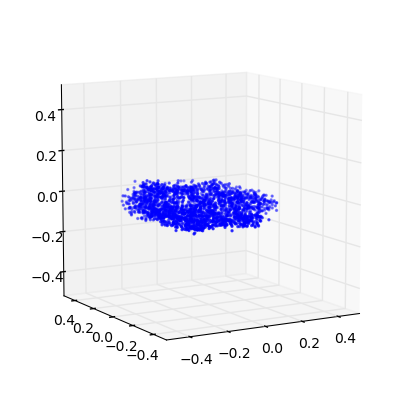

151 (-0.2641016376018524, -0.033106865186709911)
152 (-0.26049220591783523, -0.026831157994456588)
153 (-0.26368344247341158, -0.030273043038323521)
154 (-0.26312522113323211, -0.03652161308564246)
155 (-0.26013546824455264, -0.035032764548668639)
156 (-0.26159523889422415, -0.031818973994813857)
157 (-0.26055321834981443, -0.032179957174230368)
158 (-0.25690328180789945, -0.040471210674149917)
159 (-0.25584724873304365, -0.036152536375448109)
160 (-0.26005297362804414, -0.034751419257372615)
161 (-0.25679966427385809, -0.033548064832575622)
162 (-0.25655103266239165, -0.039276236714795229)
163 (-0.25605547912418841, -0.040158182964660227)
164 (-0.25332418613135815, -0.038046048139221966)
165 (-0.25474781148135661, -0.03890644661150873)
166 (-0.25339810080826281, -0.03895510013680905)
167 (-0.25365367062389849, -0.038682344974949955)
168 (-0.25408993765711785, -0.037277009279932827)
169 (-0.25417975559830663, -0.043369446834549311)
170 (-0.25154339782893659, -0.041451015777420254)
171 

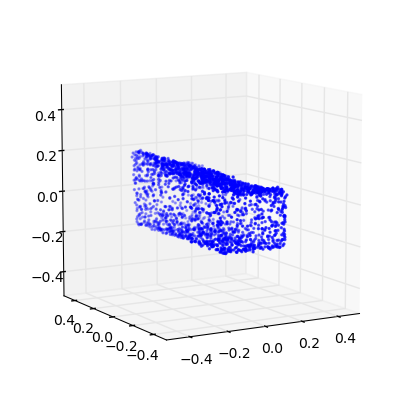

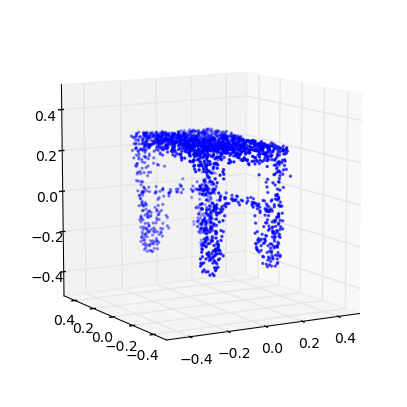

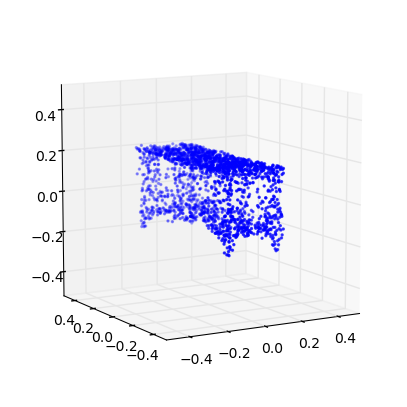

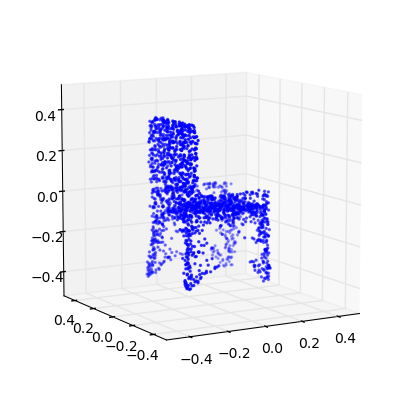

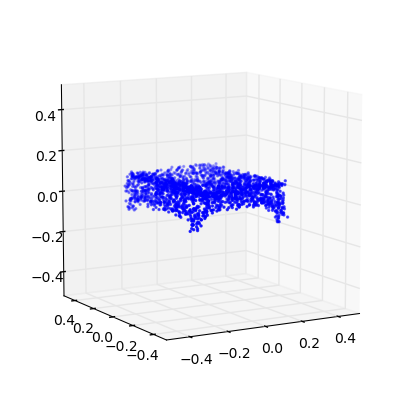

201 (-0.23553201735019683, -0.051978209149092437)
202 (-0.23661727041006089, -0.048768934817053376)
203 (-0.23348259709775449, -0.045429274725029244)
204 (-0.23308396831154823, -0.05366028035059571)
205 (-0.23391904033720493, -0.04690061322180554)
206 (-0.23183641083538531, -0.047239249770063906)
207 (-0.23240141816437243, -0.047515821945853534)
208 (-0.23169727034866811, -0.050566138885915282)
209 (-0.23292693115770816, -0.051561822462826964)
210 (-0.23129813201725483, -0.049379479745402931)
211 (-0.23118565559387208, -0.050697460444644092)
212 (-0.23086141943931579, -0.048963069682940841)
213 (-0.22970680527389051, -0.057763239019550383)
214 (-0.2293860463052988, -0.052287826547399163)
215 (-0.22922671221196653, -0.052180687244981525)
216 (-0.22834546536207198, -0.054877261212095615)
217 (-0.22705783128738402, -0.052052828157320617)
218 (-0.22843215629458427, -0.055159109574742612)
219 (-0.22732166558504105, -0.058254238311201335)
220 (-0.22701392590999603, -0.05339679897297174)
221 

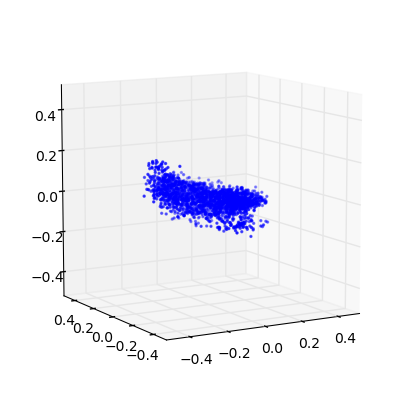

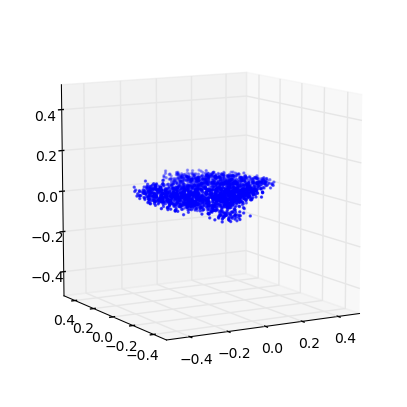

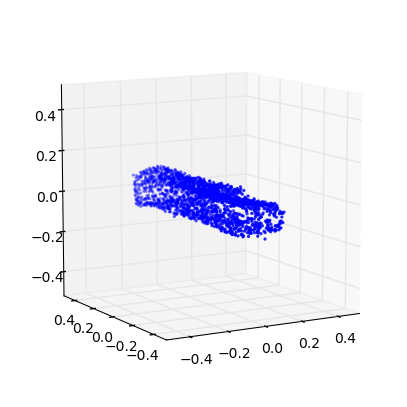

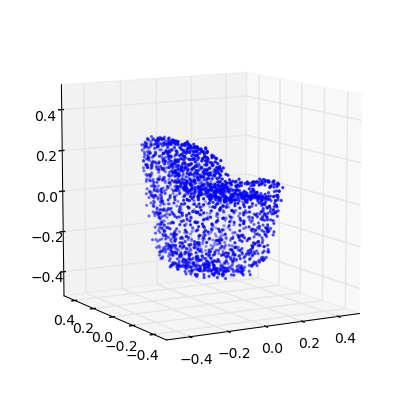

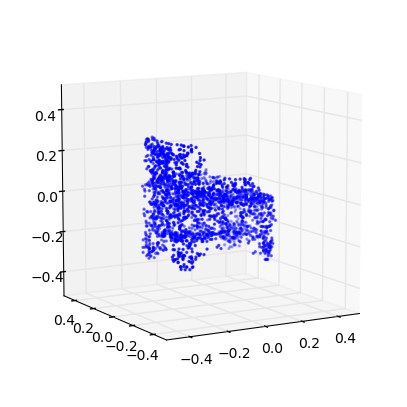

251 (-0.21462225891649722, -0.061769454972818494)
252 (-0.21138320878148079, -0.064006224041804671)
253 (-0.2152138178050518, -0.059005923895165326)
254 (-0.21194497071206569, -0.064791462011635298)
255 (-0.21188555076718329, -0.058537427708506583)
256 (-0.21162417262792588, -0.062349581392481923)
257 (-0.21037870034575462, -0.060729749780148265)
258 (-0.20966878481209278, -0.0645826487801969)
259 (-0.21240252800285817, -0.064760544383898375)
260 (-0.21024875283241273, -0.061659363890066744)
261 (-0.21000484317541124, -0.066169068403542045)
262 (-0.20835185199975967, -0.065052278805524111)
263 (-0.20961024455726146, -0.069904427789151666)
264 (-0.20931361392140388, -0.064602338476106524)
265 (-0.20915388092398643, -0.066529888287186617)
266 (-0.2102511379122734, -0.064771870896220204)
267 (-0.20845385491847992, -0.061724996473640201)
268 (-0.20772495403885841, -0.064590498432517046)
269 (-0.20871459081768989, -0.062258958490565418)
270 (-0.20581877373158933, -0.064386225398629898)
271 

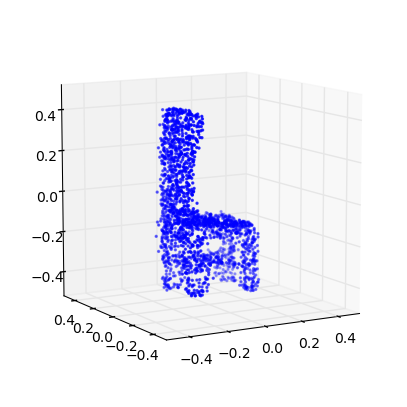

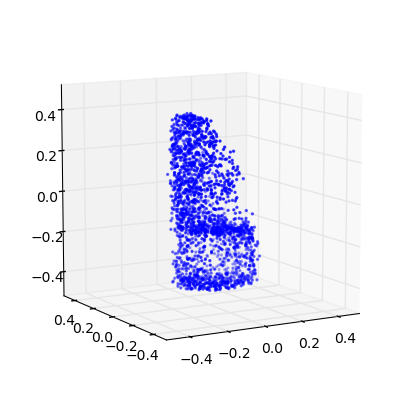

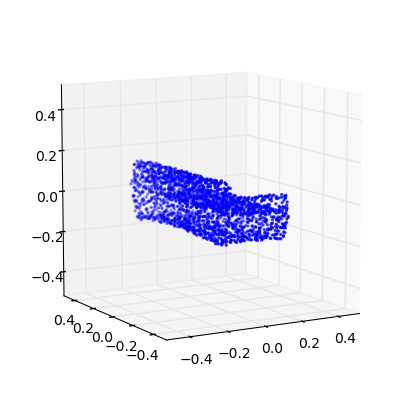

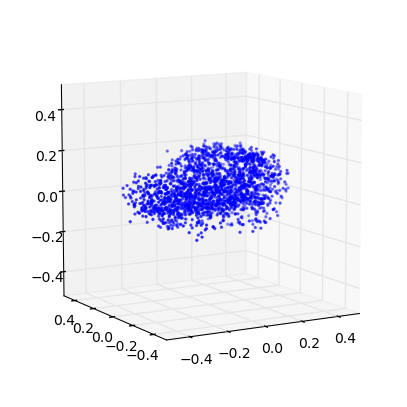

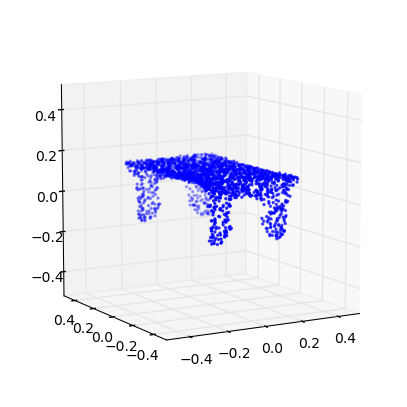

301 (-0.19401900008320808, -0.068315957952290771)
302 (-0.19643597558140755, -0.061081696813926098)
303 (-0.19683843545615673, -0.065017416514456278)
304 (-0.19475495934486389, -0.067959354678168896)
305 (-0.19641524434089661, -0.064714753348380324)
306 (-0.19487201035022736, -0.064453368959948423)
307 (-0.19597054012119769, -0.067349307611584669)
308 (-0.19548068158328533, -0.069754503853619101)
309 (-0.19334425926208496, -0.058727149618789554)
310 (-0.1941567362844944, -0.06452470226213336)
311 (-0.1977372481673956, -0.065706468001008031)
312 (-0.19224331103265285, -0.068630408216267827)
313 (-0.19428027004003526, -0.061441247584298253)
314 (-0.19277627505362033, -0.066989271435886621)
315 (-0.19421937569975853, -0.066465617436915633)
316 (-0.19318795643746853, -0.067734504863619802)
317 (-0.19186398953199388, -0.063423029705882067)
318 (-0.19180994637310506, -0.064463709387928253)
319 (-0.19327220000326634, -0.062784757674671704)
320 (-0.1934584989398718, -0.065474267117679119)
321 

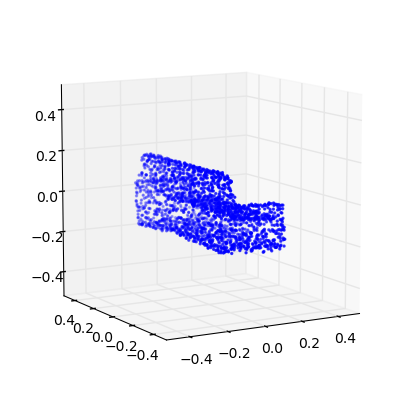

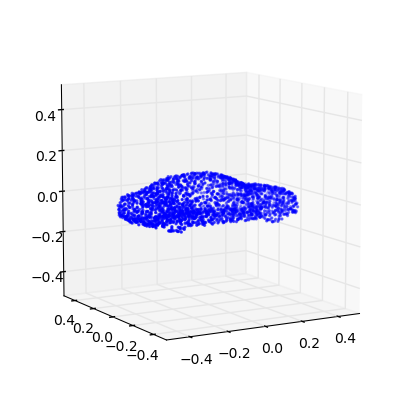

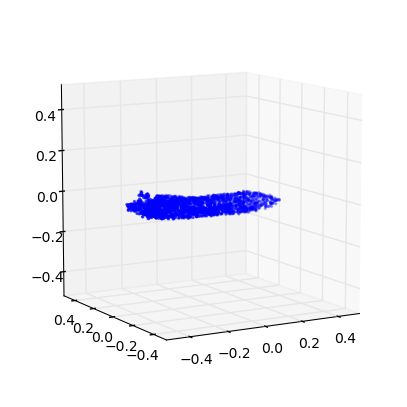

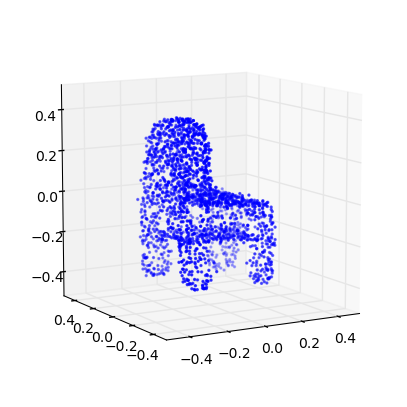

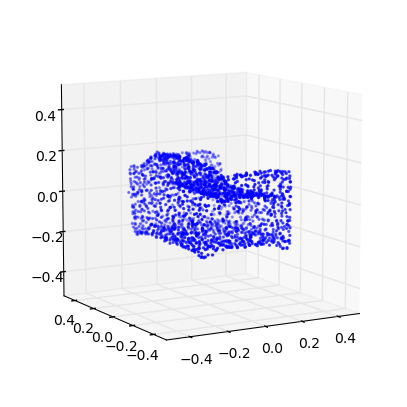

351 (-0.18336382798850537, -0.071517088264226911)
352 (-0.18471283815801143, -0.068231665994971991)
353 (-0.18318560607731343, -0.070534914638847118)
354 (-0.18290674328804016, -0.068019644916057581)
355 (-0.18341718435287477, -0.066111408080905681)
356 (-0.18169228434562684, -0.066409455239772791)
357 (-0.18417281679809094, -0.069821295794099569)
358 (-0.18225377112627028, -0.072177790012210613)
359 (-0.18193370953202248, -0.067396587040275333)
360 (-0.18113858558237553, -0.066198578942567116)
361 (-0.18198103606700897, -0.070333503978326911)
362 (-0.18294479817152023, -0.070153931900858876)
363 (-0.1817349101603031, -0.069472792558372021)
364 (-0.1820552885904908, -0.068008494004607206)
365 (-0.18229904837906361, -0.065769968274980786)
366 (-0.18028617337346076, -0.069546735007315869)
367 (-0.18072200626134871, -0.06556378751993179)
368 (-0.18024598605930806, -0.068518765736371279)
369 (-0.18154154904186726, -0.066975814290344715)
370 (-0.18064863570034503, -0.070200661569833761)
371

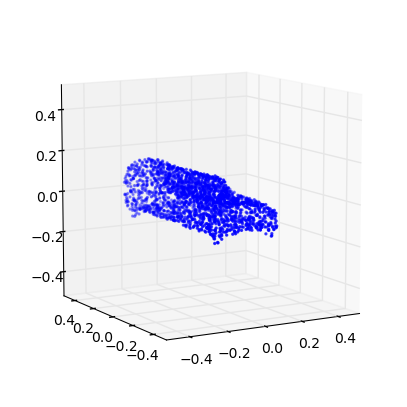

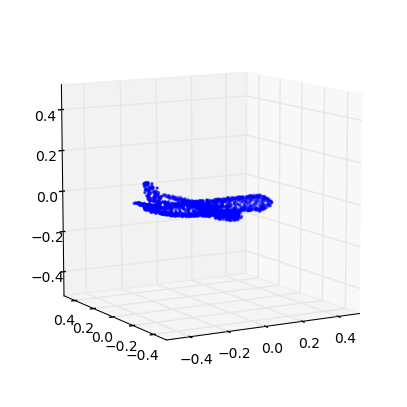

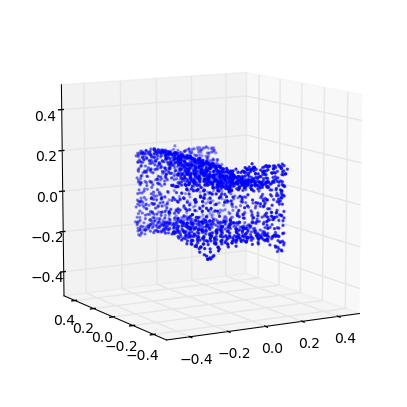

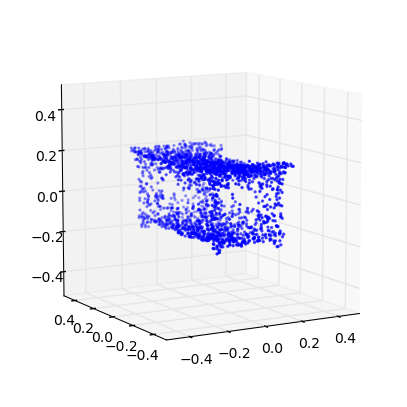

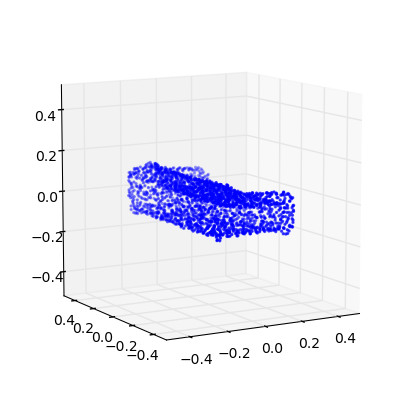

401 (-0.17537720970809459, -0.072079138550907376)
402 (-0.17525691863149404, -0.074604513589292765)
403 (-0.17496553577482701, -0.069366360921412712)
404 (-0.17292125895619392, -0.070449539460241795)
405 (-0.17504578735679388, -0.074278976861387486)
406 (-0.17372297868132591, -0.069912833720445627)
407 (-0.17488617196679115, -0.076203754451125857)
408 (-0.17435940094292163, -0.07457829313352704)
409 (-0.1726953997462988, -0.07293388647958636)
410 (-0.17304641291499137, -0.067379229236394167)
411 (-0.17452928431332113, -0.072981356177479029)
412 (-0.17309816360473632, -0.0758813644759357)
413 (-0.17313168209046126, -0.077384395152330393)
414 (-0.17292923774570226, -0.07492045676335693)
415 (-0.17226679399609565, -0.075013432092964655)
416 (-0.17194807402789591, -0.07534144921228289)
417 (-0.17189959615468978, -0.071387975336983794)
418 (-0.1707641402631998, -0.068034499417990446)
419 (-0.1731697829812765, -0.07538358392193914)
420 (-0.17362472690641881, -0.071492818184196949)
421 (-0.17

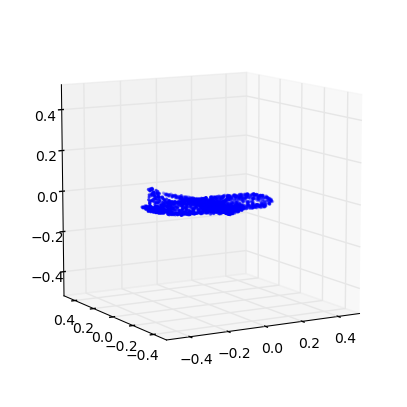

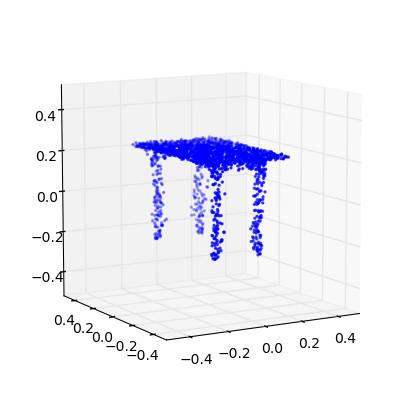

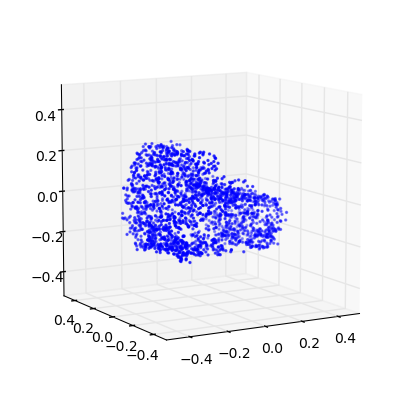

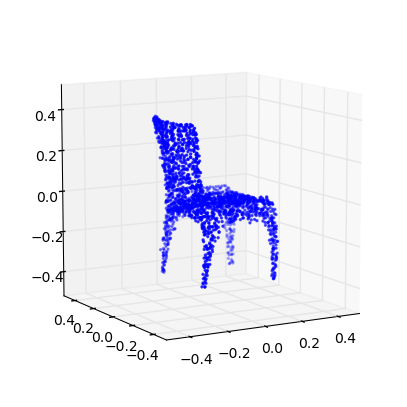

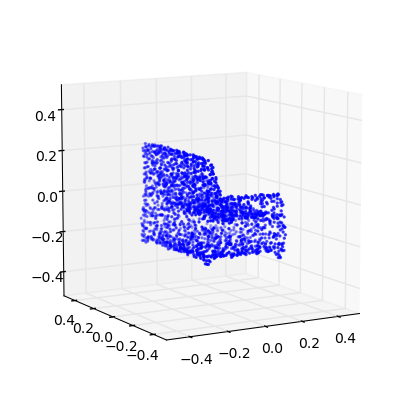

451 (-0.16599189411848783, -0.066270108846947548)
452 (-0.16775518659502267, -0.070467564091086385)
453 (-0.16720056682825088, -0.070090487040579325)
454 (-0.16487272176891565, -0.067506534978747368)
455 (-0.16742386680096388, -0.066385442297905689)
456 (-0.16743144586682321, -0.068579471297562117)
457 (-0.16563474468886852, -0.065696947369724507)
458 (-0.16713954545557499, -0.067786884540691969)
459 (-0.16555792130529881, -0.067509461939334867)
460 (-0.16688374761492014, -0.067337583098560569)
461 (-0.16709282021969557, -0.069415303412824869)
462 (-0.1659493676945567, -0.064887349866330629)
463 (-0.16675274252891539, -0.062451371643692258)
464 (-0.16779107213020325, -0.064157334063202148)
465 (-0.16684712965041398, -0.067322047706693408)
466 (-0.16523215256631374, -0.06621931451372802)
467 (-0.1652790680900216, -0.065610537678003317)
468 (-0.16237974487245083, -0.058927160128951071)
469 (-0.16756647143512965, -0.063405611738562587)
470 (-0.16613470360636712, -0.065696913283318281)
471

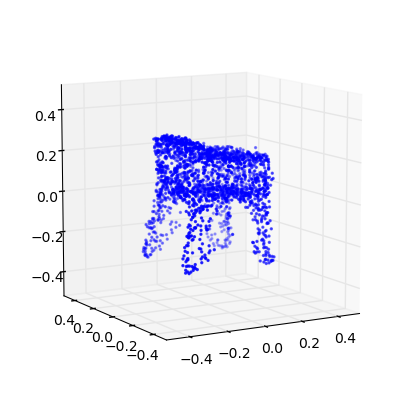

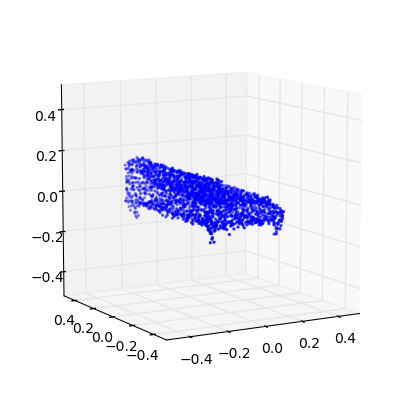

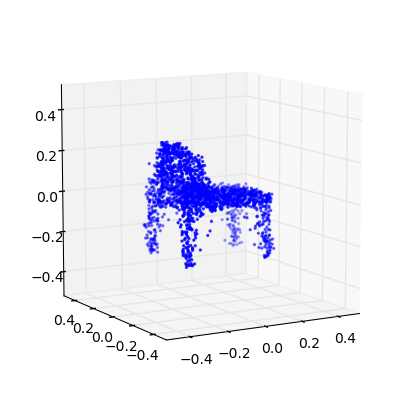

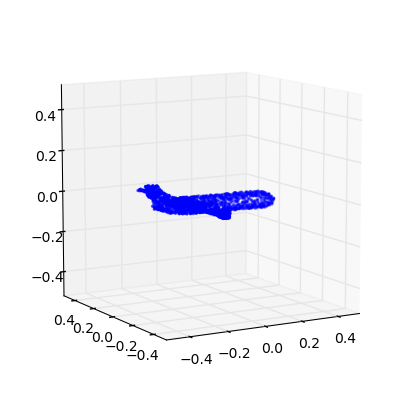

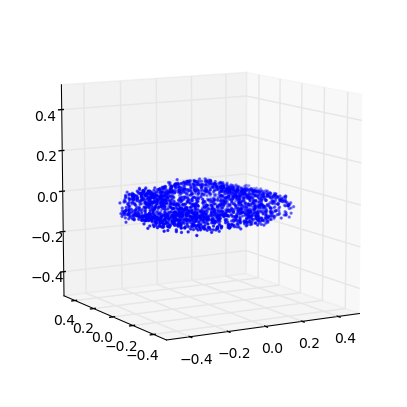

501 (-0.16131139278411866, -0.05989249306730926)
502 (-0.16304830871522427, -0.064099654462188488)
503 (-0.16135470479726791, -0.06116585908457637)
504 (-0.16130764830857516, -0.062631868291646242)
505 (-0.16210388902574777, -0.061418474745005371)
506 (-0.16213706716895104, -0.062422088067978623)
507 (-0.16052310787141322, -0.06058049565181136)
508 (-0.16102392211556435, -0.062320363055914638)
509 (-0.16054933376610278, -0.061838708538562062)
510 (-0.16207614563405515, -0.062369425501674416)
511 (-0.16027239345014097, -0.059859752003103492)
512 (-0.16113918140530586, -0.057594074215739963)
513 (-0.15919268082827329, -0.063888201722875237)
514 (-0.16160099059343339, -0.061193456407636404)
515 (-0.16148332357406617, -0.061623631324619052)
516 (-0.15930340599268675, -0.06036623269319534)
517 (-0.15898787554353475, -0.063251003064215189)
518 (-0.16080478534102441, -0.058821078296750783)
519 (-0.16010821763426064, -0.062446567323058845)
520 (-0.16080444835126401, -0.062964032683521506)
521 

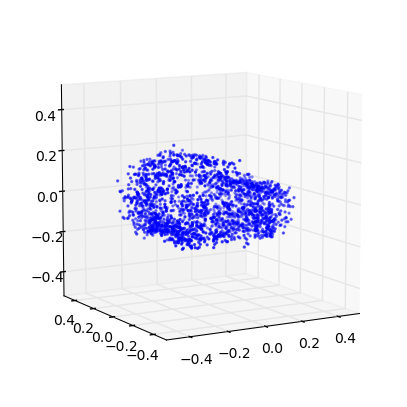

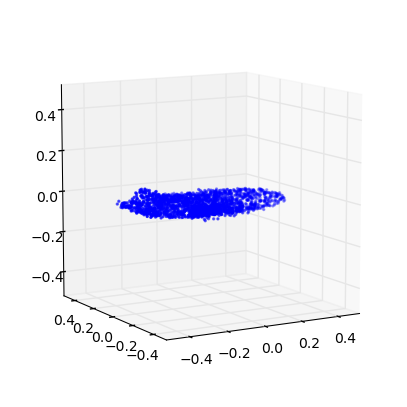

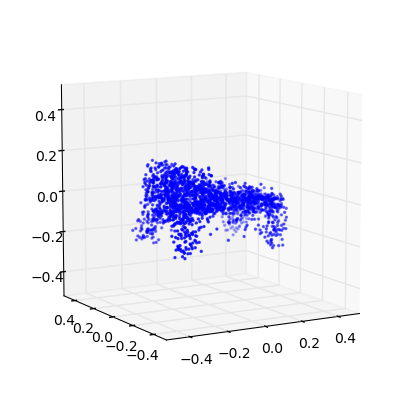

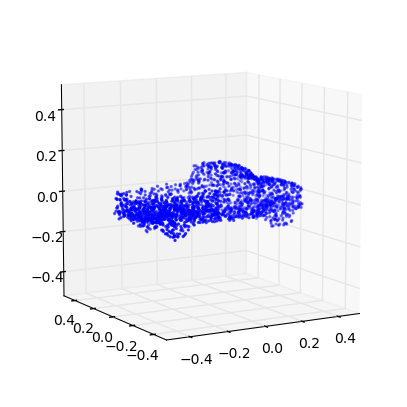

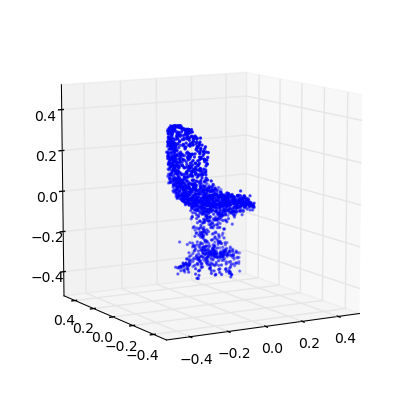

551 (-0.1575001149997115, -0.053470064699649808)
552 (-0.1573917941004038, -0.056163082504644989)
553 (-0.15693747192621232, -0.052714777458459136)
554 (-0.15763229507952928, -0.052561213634908198)
555 (-0.1561881760135293, -0.051545178564265368)
556 (-0.15760008111596108, -0.052338769240304825)
557 (-0.15728517513722182, -0.054020021576434374)
558 (-0.15803779974579812, -0.053231533290818332)
559 (-0.15563331268727779, -0.054961886676028374)
560 (-0.15562453892081976, -0.049621153622865677)
561 (-0.15782016649842262, -0.052543259598314761)
562 (-0.15654818072915078, -0.05949710747227073)
563 (-0.15694162011146545, -0.053485795855522156)
564 (-0.15745852053165435, -0.056335062999278304)
565 (-0.15692766007035971, -0.051316655706614256)
566 (-0.15710334163159131, -0.059223560988903044)
567 (-0.15694290209561587, -0.058139709522947669)
568 (-0.15566481191664935, -0.061039501521736386)
569 (-0.15574663788080215, -0.050859576929360627)
570 (-0.1548666574433446, -0.056057632667943835)
571 (

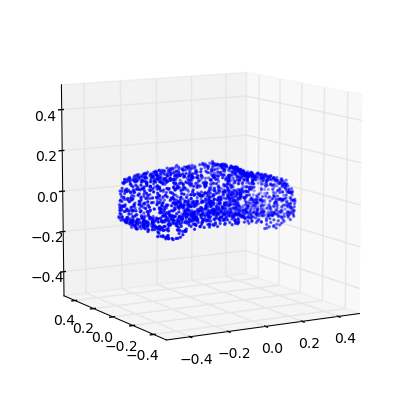

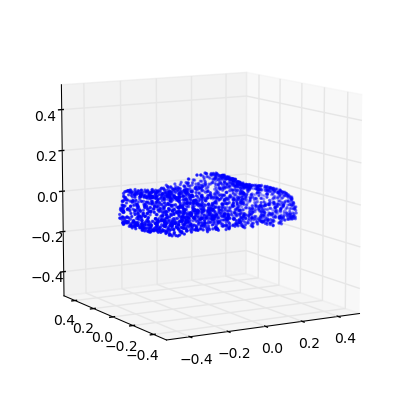

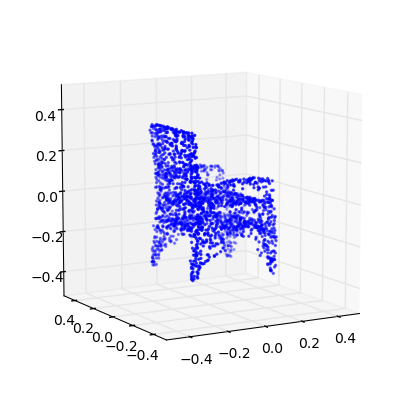

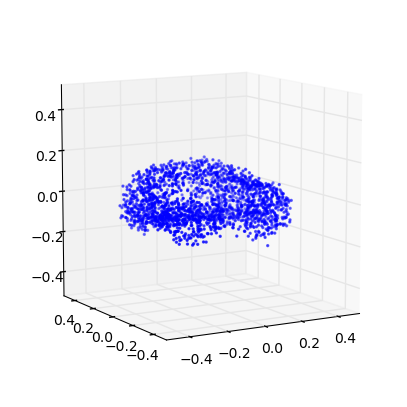

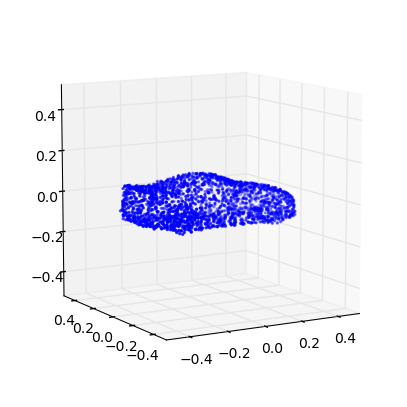

601 (-0.15454349853098392, -0.049375127255916598)
602 (-0.15511366695165635, -0.053764020418748261)
603 (-0.1524612870439887, -0.056375095667317507)
604 (-0.15324606239795685, -0.058959766477346423)
605 (-0.15305310785770415, -0.055782058648765086)
606 (-0.15362231090664863, -0.054831002885475752)
607 (-0.15316125839948655, -0.056272722641006113)
608 (-0.15426877535879613, -0.05062253065407276)
609 (-0.15290727391839026, -0.054782533086836338)
610 (-0.15290804523974658, -0.052696394268423319)
611 (-0.15346765659749509, -0.049325567157939079)
612 (-0.15272984981536866, -0.055658447276800874)
613 (-0.15344267804175615, -0.054904934577643873)
614 (-0.15386774919927121, -0.050744574004784229)
615 (-0.15310647435486316, -0.046341302583459767)
616 (-0.1518579363822937, -0.058700939035043122)
617 (-0.15394029002636672, -0.05290181543678045)
618 (-0.15247105367481709, -0.052782263280823825)
619 (-0.1539004161953926, -0.053198571689426898)
620 (-0.1516287487745285, -0.052724070008844139)
621 (-

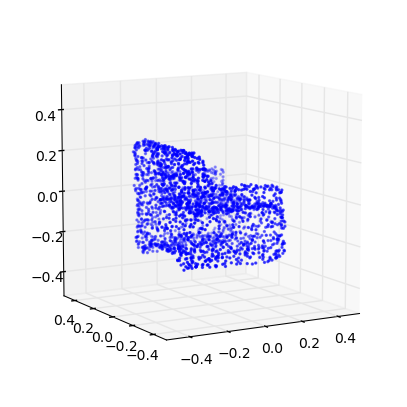

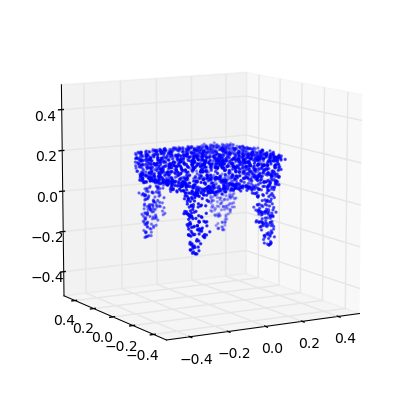

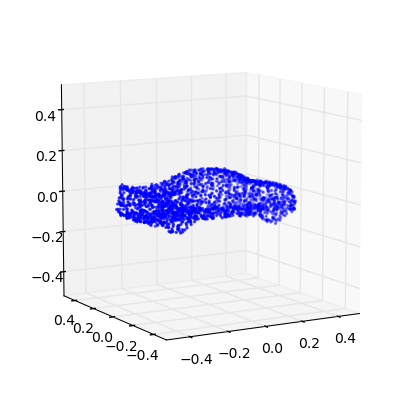

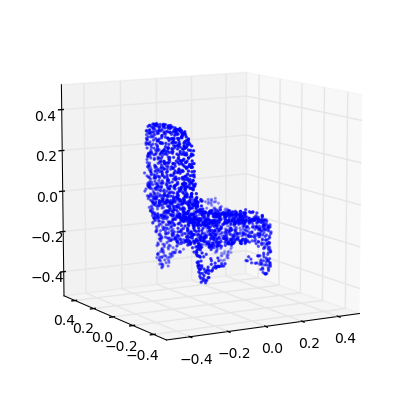

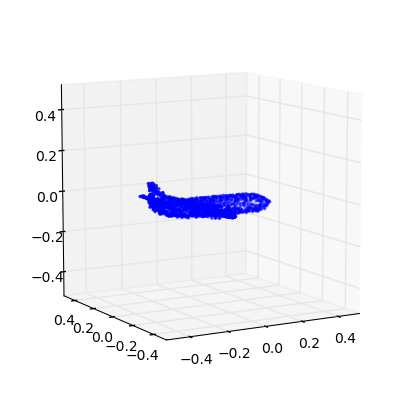

651 (-0.15129541903734206, -0.056002777162939311)
652 (-0.15248294286429881, -0.053786273580044508)
653 (-0.15170145254582168, -0.042925486876629296)
654 (-0.15139649383723736, -0.053282131580635904)
655 (-0.15132097713649273, -0.054548249579966068)
656 (-0.15143016379326582, -0.054434413276612761)
657 (-0.14908231746405362, -0.049745761789381504)
658 (-0.15170308560132981, -0.05157940648496151)
659 (-0.15021694712340833, -0.052527939807623623)
660 (-0.15130077335983516, -0.053473631595261396)
661 (-0.15086654923856258, -0.053549095476046207)
662 (-0.15074994925409554, -0.047393353201914581)
663 (-0.14987855505198242, -0.045948486239649353)
664 (-0.15150127004832029, -0.053947815997526051)
665 (-0.15035216774791479, -0.054626503866165875)
666 (-0.14939934421330692, -0.050819840561598537)
667 (-0.15095236942172049, -0.054775315057486298)
668 (-0.15066532831639051, -0.052774220262654124)
669 (-0.15092397313565015, -0.050211736746132371)
670 (-0.14920167330652476, -0.053375458158552644)
6

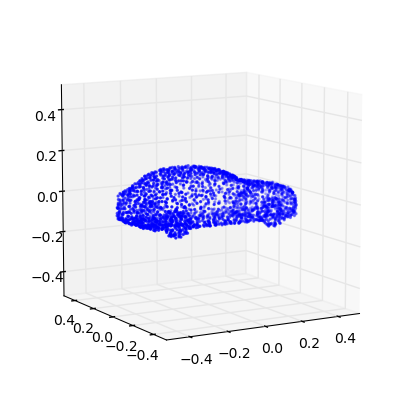

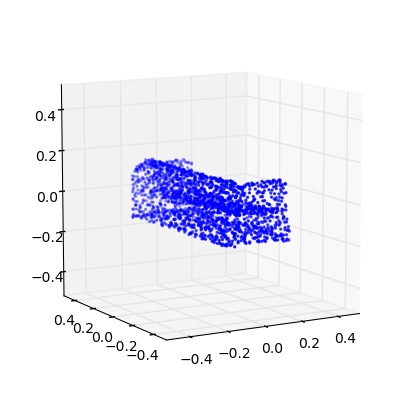

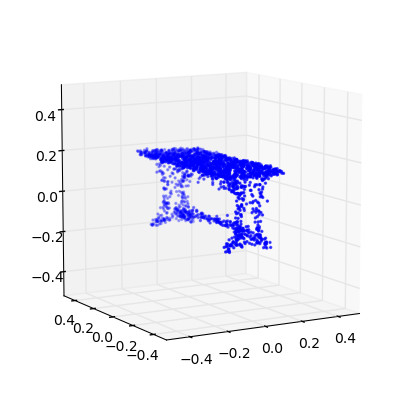

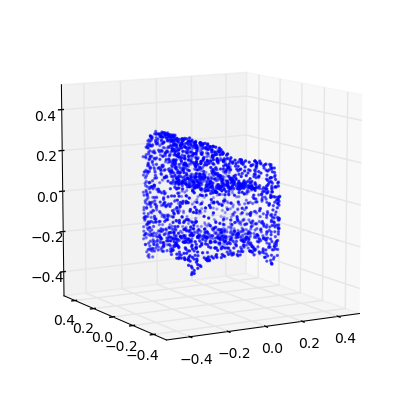

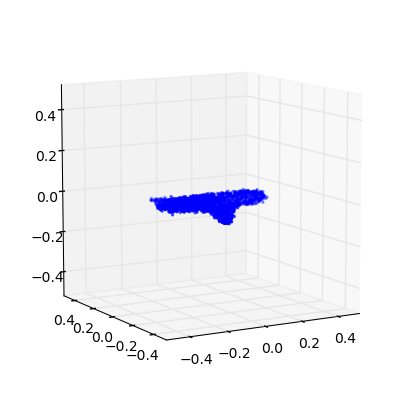

701 (-0.14697458162903787, -0.047792527498677372)
702 (-0.14761407673358917, -0.041243136487901212)
703 (-0.14821072127670049, -0.042754956823773685)
704 (-0.14768311291933059, -0.044968843925744295)
705 (-0.14941289361566304, -0.046569702913984656)
706 (-0.14912571497261523, -0.04143518165219575)
707 (-0.14808992009609936, -0.048858226137235762)
708 (-0.1475398414209485, -0.051038942858576776)
709 (-0.14715831670910121, -0.053710915660485622)
710 (-0.14960038594901562, -0.052302237041294573)
711 (-0.1476747052744031, -0.051684468332678077)
712 (-0.1472039595618844, -0.050520084099844098)
713 (-0.14795033663511276, -0.044611876038834451)
714 (-0.1467878968268633, -0.0486222006380558)
715 (-0.14741179764270781, -0.050087375566363335)
716 (-0.14760279331356288, -0.04645878621668089)
717 (-0.14639928083866835, -0.053464196855202317)
718 (-0.14635294411331415, -0.049293523561209439)
719 (-0.14704074669629336, -0.049956636456772688)
720 (-0.14821143362671138, -0.045163788669742647)
721 (-0.

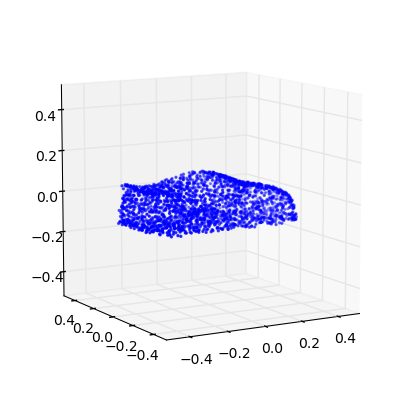

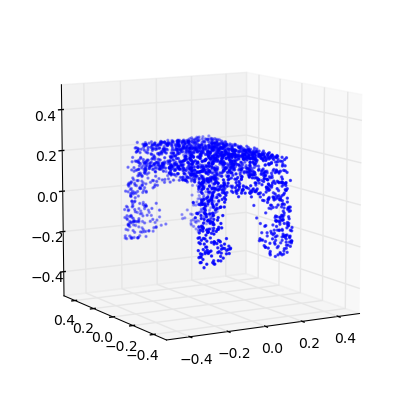

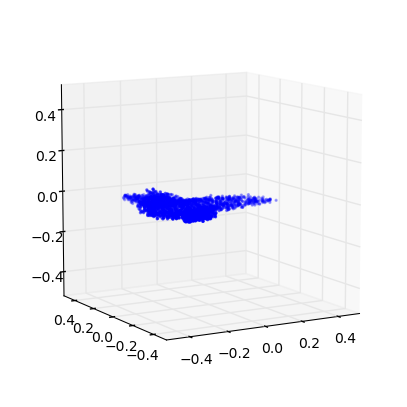

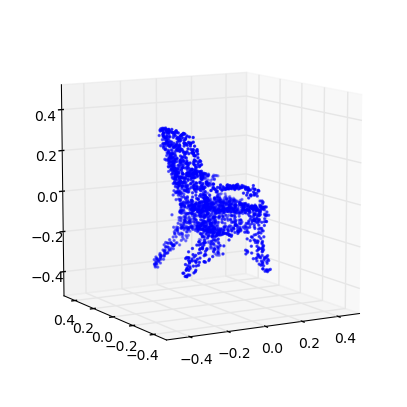

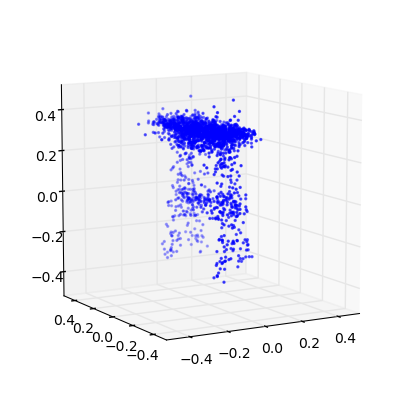

751 (-0.14468897342681886, -0.048340058187022805)
752 (-0.14544451281428336, -0.049583650939166543)
753 (-0.14733208935707809, -0.054115160834044218)
754 (-0.1461709839105606, -0.050010961107909681)
755 (-0.14587392784655095, -0.044842973956838249)
756 (-0.14594619806855916, -0.052753351349383595)
757 (-0.14579966288059951, -0.045847833831794561)
758 (-0.14433732945472003, -0.050060099270194766)
759 (-0.145791947953403, -0.047607894288375974)
760 (-0.14641501203179361, -0.048239538166671994)
761 (-0.14448807928711177, -0.053304373845458032)
762 (-0.14458592869341375, -0.049120323639363049)
763 (-0.14523973792791367, -0.045630402350798252)
764 (-0.14549215164035559, -0.047820017673075199)
765 (-0.14409089837223291, -0.048069471959024668)
766 (-0.14476970661431551, -0.04629667508415878)
767 (-0.14565426252782346, -0.049234019778668883)
768 (-0.14488410755991935, -0.04815436163917184)
769 (-0.14455491118133068, -0.044112841505557297)
770 (-0.14407568704336882, -0.046325844177044925)
771 (

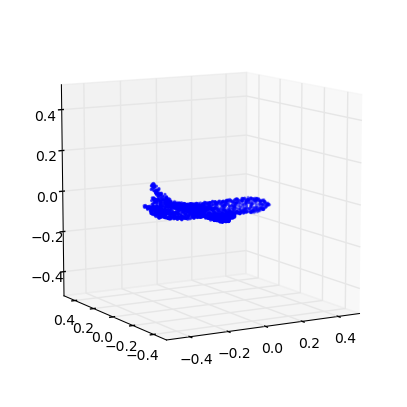

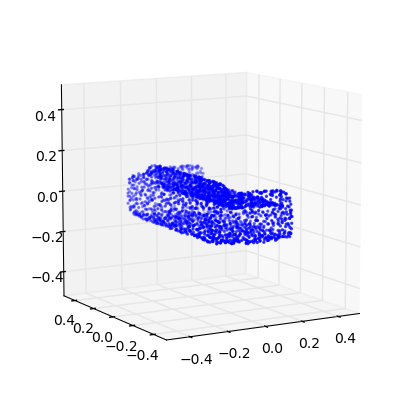

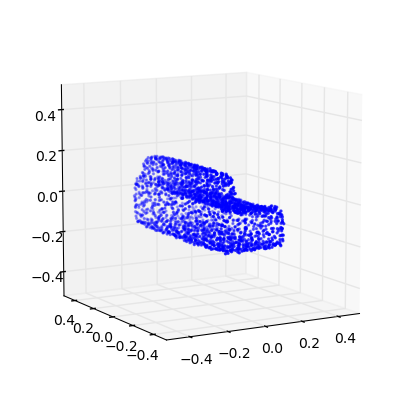

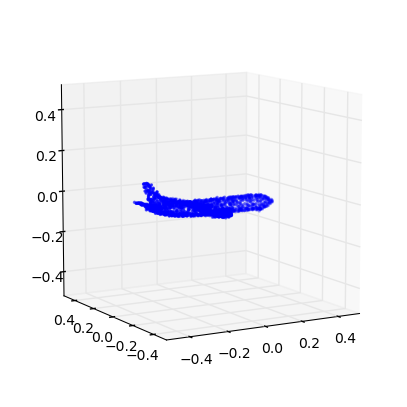

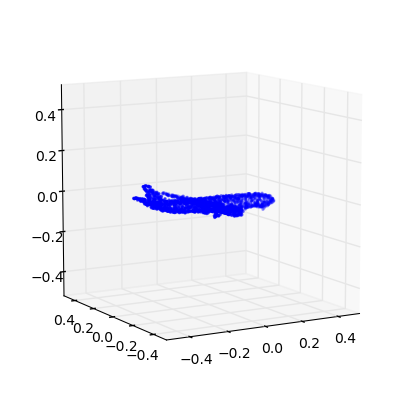

801 (-0.14214376844465731, -0.043563893903046845)
802 (-0.14389013163745404, -0.052060360880568625)
803 (-0.14338852521032094, -0.051262056035920975)
804 (-0.14225502744317053, -0.049276920827105643)
805 (-0.14311294503509997, -0.04990649097599089)
806 (-0.14297250252217053, -0.044122538366355005)
807 (-0.14162747688591482, -0.042734505771659312)
808 (-0.1425072079151869, -0.049180657183751461)
809 (-0.14282798040658234, -0.047226019715890286)
810 (-0.14170157942920925, -0.044959949236363171)
811 (-0.14405231159180404, -0.04255419566761702)
812 (-0.14212491381913422, -0.048726489115506408)
813 (-0.14340817559510469, -0.050054641766473652)
814 (-0.14244480449706315, -0.041519435727968811)
815 (-0.14163986455649138, -0.047850639047101143)
816 (-0.14205343089997768, -0.050669661373831332)
817 (-0.14140920523554087, -0.047888921340927482)
818 (-0.14249905973672866, -0.048099192557856441)
819 (-0.14353255588561298, -0.051261240942403676)
820 (-0.14200029764324426, -0.047657689405605198)
821

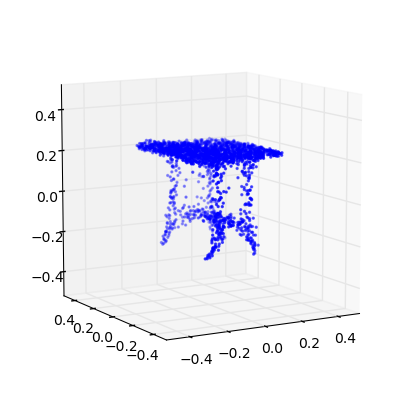

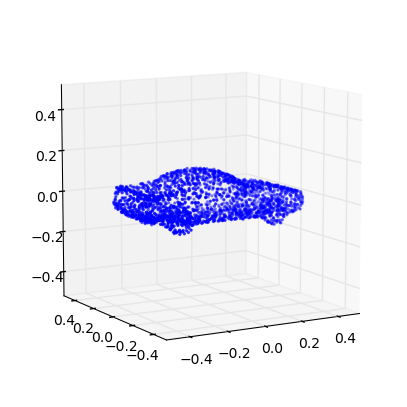

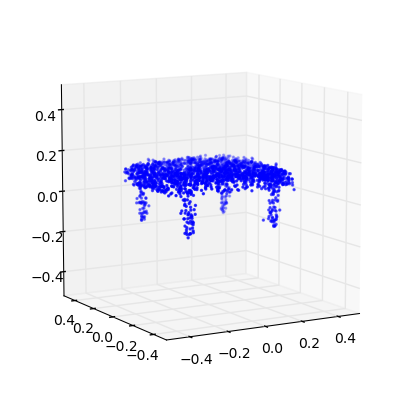

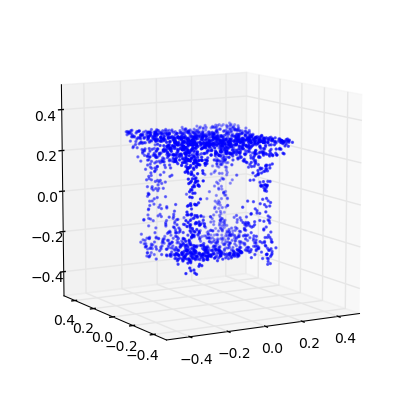

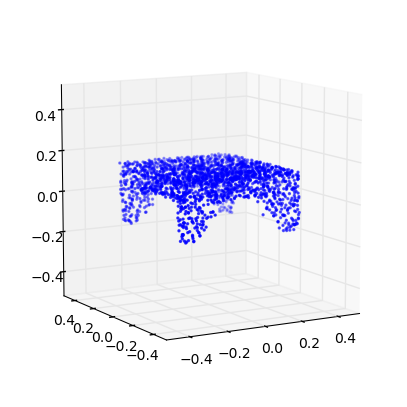

851 (-0.14136845465749504, -0.047079877159558234)
852 (-0.14103338800370693, -0.043247839668765664)
853 (-0.14067670259624721, -0.04754160409793258)
854 (-0.14013145122677087, -0.048274898109957574)
855 (-0.14067318592220546, -0.056807100679725407)
856 (-0.1415767976641655, -0.051044111605733633)
857 (-0.14105441290885209, -0.046862737741321325)
858 (-0.14023735113441943, -0.049325696611776951)
859 (-0.14157603114843367, -0.054214302590116857)
860 (-0.14100042179226877, -0.046938227722421288)
861 (-0.14069089688360692, -0.050724730733782052)
862 (-0.14038613252341747, -0.046885765902698037)
863 (-0.14018562223762274, -0.052080570068210361)
864 (-0.14005956958979368, -0.050100369937717916)
865 (-0.14241073586046696, -0.052433408610522744)
866 (-0.13942501772195101, -0.049619631236419083)
867 (-0.13998101703822613, -0.046346480026841164)
868 (-0.14161416087299586, -0.051538040046580136)
869 (-0.13944548297673465, -0.046562625654041769)
870 (-0.14038076434284449, -0.048662393679842354)
87

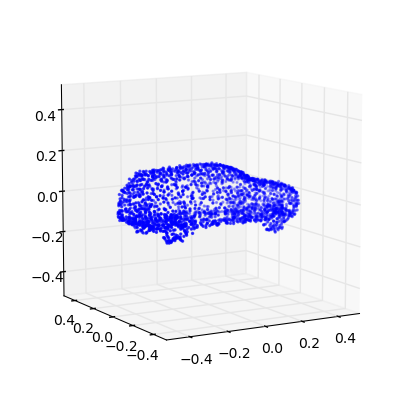

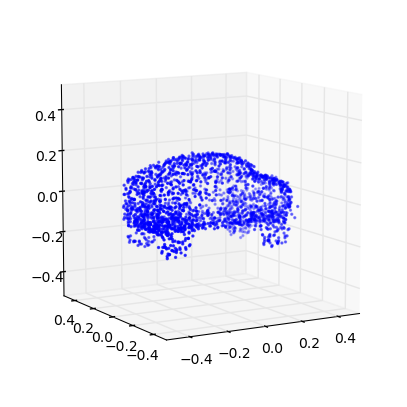

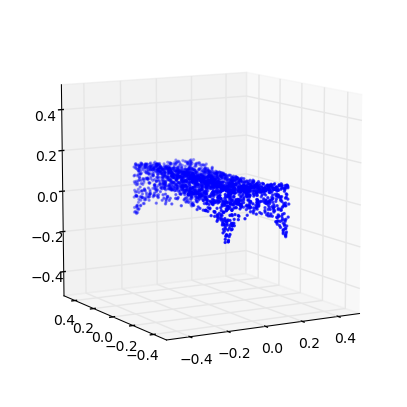

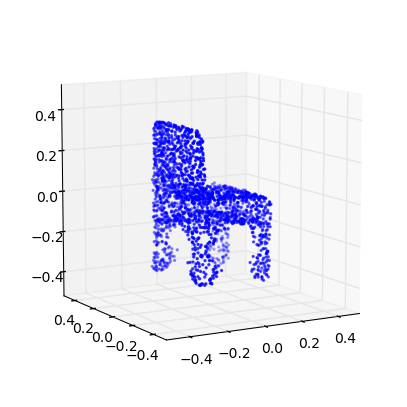

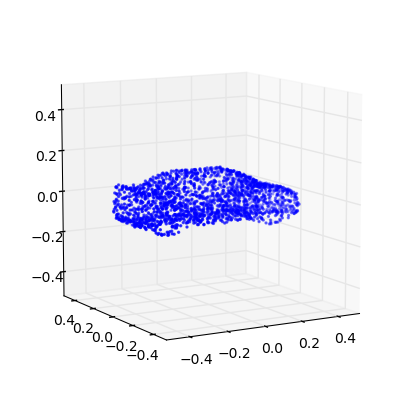

901 (-0.13841052766889334, -0.045131220994517204)
902 (-0.14026480048894882, -0.048831173172220591)
903 (-0.13881643865257501, -0.044698352878913286)
904 (-0.1374672368913889, -0.040244113595690578)
905 (-0.13883554071187973, -0.043698266777209935)
906 (-0.13802162509411572, -0.045478752674534918)
907 (-0.13953346144407988, -0.04302924987860024)
908 (-0.13853575121611356, -0.045437816111370918)
909 (-0.13847226984798908, -0.041643453668802975)
910 (-0.13716780096292497, -0.045132638514041902)
911 (-0.13837019745260476, -0.046112985210493208)
912 (-0.1379535874724388, -0.044180968822911379)
913 (-0.13927895225584508, -0.044607767835259438)
914 (-0.13711893495172262, -0.044666578713804486)
915 (-0.13934483129531144, -0.043868514569476248)
916 (-0.1380227528139949, -0.047782664257101717)
917 (-0.13886050727218391, -0.053503979044035074)
918 (-0.13964157037436961, -0.045913756964728235)
919 (-0.13691102366894484, -0.045537299104034902)
920 (-0.13780906833708287, -0.043056254647672175)
921 

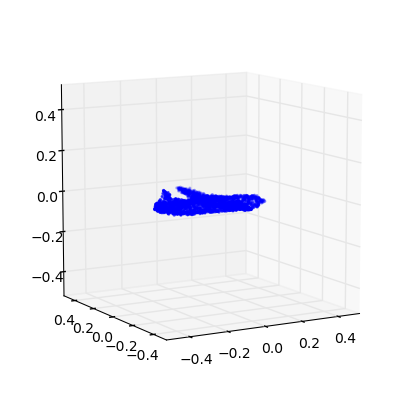

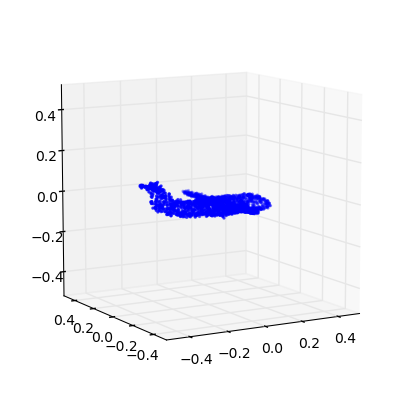

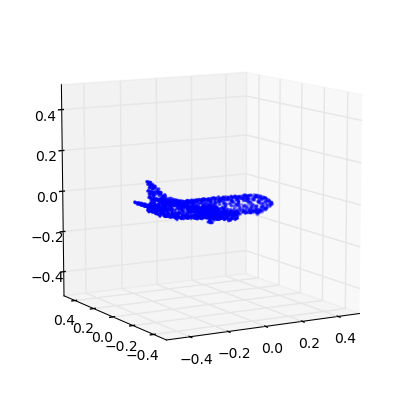

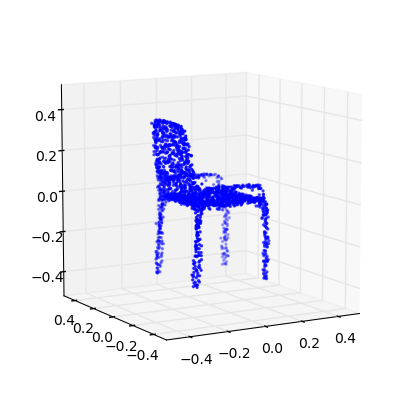

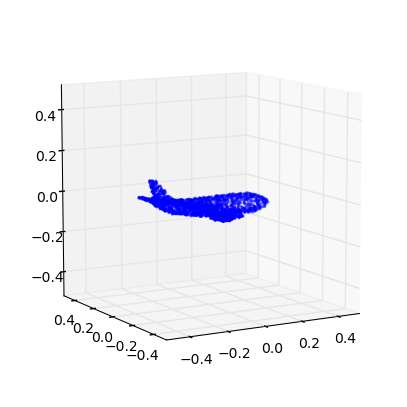

951 (-0.13793157014995813, -0.04612245196476579)
952 (-0.13620707470923663, -0.049624134134501216)
953 (-0.13723252296447755, -0.044603872764855626)
954 (-0.13590499520301819, -0.050929709430783988)
955 (-0.13647669013589619, -0.045979019533842799)
956 (-0.13691578742116689, -0.046488487441092727)
957 (-0.13624046988785266, -0.040951230982318523)
958 (-0.13622365348041057, -0.044516918109729887)
959 (-0.13779229503124951, -0.036745768086984751)
960 (-0.1365607574954629, -0.041133691905997694)
961 (-0.13783903490751981, -0.043851618329063057)
962 (-0.13698523502796889, -0.045654663583263755)
963 (-0.13877375811338424, -0.043744461983442305)
964 (-0.13422586459666491, -0.045689918333664536)
965 (-0.13504408270120621, -0.046847883984446524)
966 (-0.13677285764366387, -0.049512409698218109)
967 (-0.13634183734655381, -0.043326860689558086)
968 (-0.13643329825252296, -0.046846068720333277)
969 (-0.13588012915104627, -0.047285137930884957)
970 (-0.13665796197950841, -0.04615135542117059)
971

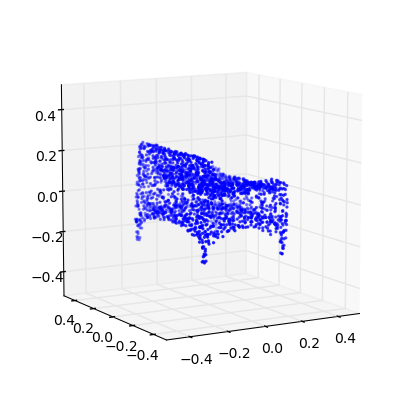

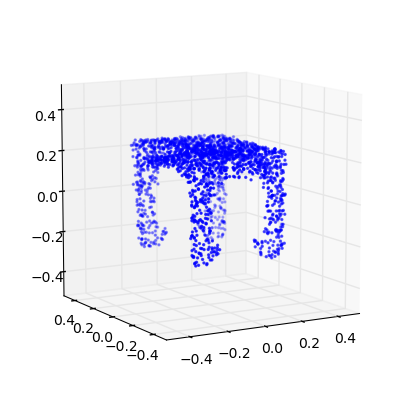

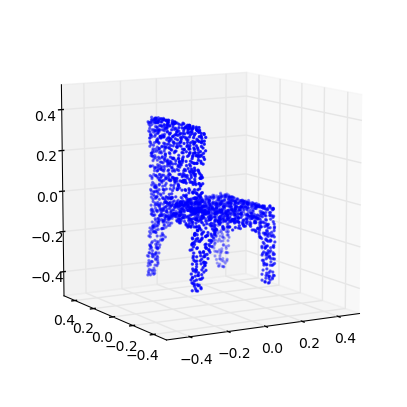

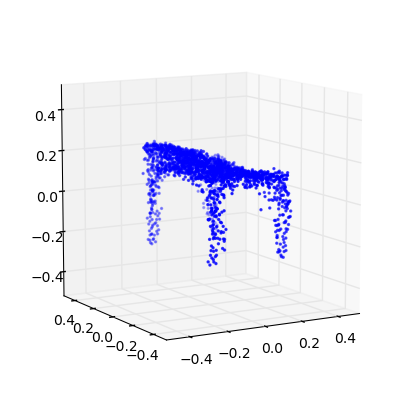

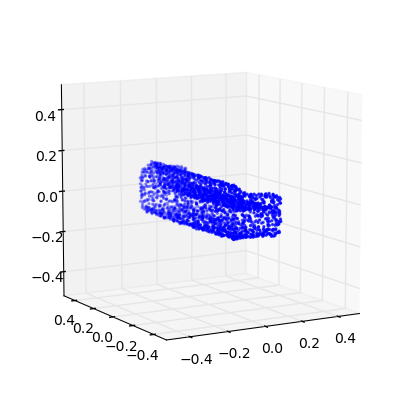

1001 (-0.13472155880182982, -0.049589933967217802)


In [23]:
if do_training:
    for _ in range(max_epochs):
        loss, duration = gan._single_epoch_train(train_data, batch_size, noise_params)
        epoch = int(gan.sess.run(gan.epoch.assign_add(tf.constant(1.0))))
        print epoch, loss
        
        if save_model and (epoch % saver_step == 0 or epoch <= 5):
            checkpoint_path = osp.join(train_dir, MODEL_SAVER_ID)
            gan.saver.save(gan.sess, checkpoint_path, global_step=gan.epoch)
        
        if save_synthetic_samples and epoch in saver_step:
            syn_latent_data = gan.generate(n_syn_samples, noise_params)
            syn_data = ae.decode(syn_latent_data)
            np.savez(osp.join(synthetic_data_out_dir, 'epoch_' + str(epoch)), syn_data)
            for k in range(5):
                Point_Cloud(syn_data[k]).plot()
            
        train_stats.append((epoch,) + loss)


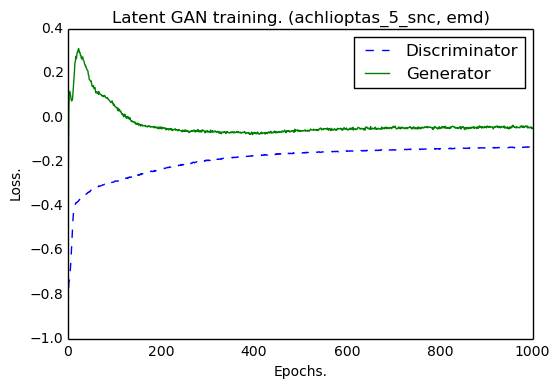

In [25]:
if plot_train_curve:
    x = range(len(train_stats))
    d_loss = [t[1] for t in train_stats]
    g_loss = [t[2] for t in train_stats]
    plt.plot(x, d_loss, '--')
    plt.plot(x, g_loss)
    plt.title('Latent GAN training. (%s, %s)' %(class_name, ae_loss))
    plt.legend(['Discriminator', 'Generator'], loc=0)
    
    plt.tick_params(axis='x', which='both', bottom='off', top='off')
    plt.tick_params(axis='y', which='both', left='off', right='off')
    
    plt.xlabel('Epochs.') 
    plt.ylabel('Loss.')